## Modeling Habitat Suitability of Sorghastrum nutans

Sorghastrum nutans (Indiangrass) is native to North America, however in the past 50 years its range has progressively moved northward (citation). To understand current and future projections of habitat suitability of this grass, I analyze multiple data layers related to soil, topography and climate.

In this notebook, I analyze the habitat suitability of two Colorado National Grasslands (Pawnee and Comanche) under current (2024) conditions and future climate conditions projected for 2050. MORE DETAILS HERE

In [3]:
# Import packages
import io
import math 
import os
from glob import glob
import earthpy as et
#import earthpy.appeears as etapp
import geopandas as gpd
import hvplot.xarray  
import hvplot.pandas
import matplotlib.pyplot as plt
import pandas as pd
import rioxarray as rxr
import rioxarray.merge as rxrmerge
import requests
import xarray as xr
import zipfile
from xrspatial import aspect
from xrspatial import slope
import warnings
warnings.filterwarnings('ignore')

### Creating data directories

In [4]:
data_dir = os.path.join(et.io.HOME, et.io.DATA_NAME, 'final-project')
boundaries_dir = os.path.join(data_dir, 'boundaries')
polaris_dir = os.path.join(data_dir, 'polaris')
elevation_dir = os.path.join(data_dir, 'elevation')
precipitation_dir = os.path.join(data_dir, 'precipitation')

for dir in [data_dir, boundaries_dir, polaris_dir, precipitation_dir, elevation_dir]:
    """
    Create directories if they don't exist
    """
    if not os.path.exists(dir):
        os.makedirs(dir)

# Define utm zone
utm = 32613

## Dowloading Data for Pawnee and Comanche National Grasslands

### Data Citation:
United States Forest Service (USFS). (2023). U.S. National Grassland Shapefiles [Data set]. USFS Enterprise Data Warehouse. Accessed 2024-11-20 from https://data.fs.usda.gov/geodata/edw/edw_resources/shp/S_USA.NationalGrassland.zip

In [5]:
# Define the download URL for the study area
usfs_grassland_url = (
    'https://data.fs.usda.gov/geodata/edw'
    '/edw_resources/shp/S_USA.NationalGrassland.zip'
)
# Check the URL is correct
try:
    grass_shapefile = os.path.join(
        boundaries_dir, 'grasslands.shp')
    if not os.listdir(boundaries_dir):
        gdf = gpd.read_file(usfs_grassland_url)
        gdf.to_file(grass_shapefile)
    else:
        gdf = gpd.read_file(grass_shapefile)
except URLError as e:
    print(f"Failed to open URL: {e.reason}")

In [8]:
# Select the two study areas and look at it
selectedgrass_gdf = (gdf.set_index('GRASSLANDN')
               .loc[[
                     'Comanche National Grassland', 
                     'Pawnee National Grassland',
                  ]])
selectedgrass_gdf

,NATIONALGR,GIS_ACRES,SHAPE_AREA,SHAPE_LEN,geometry
GRASSLANDN,,,,,
Comanche National Grassland,295522010328,444413.904,0.183064,26.658022,"MULTIPOLYGON (((-104.02263 37.69224, -104.0225..."
Pawnee National Grassland,295523010328,208424.885,0.089972,15.341594,"MULTIPOLYGON (((-104.58106 40.82664, -104.5810..."


<Axes: >

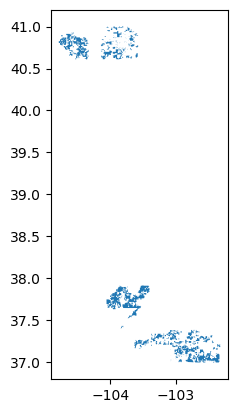

In [9]:
# Make a quick plot to check data
selectedgrass_gdf.plot()

<Axes: >

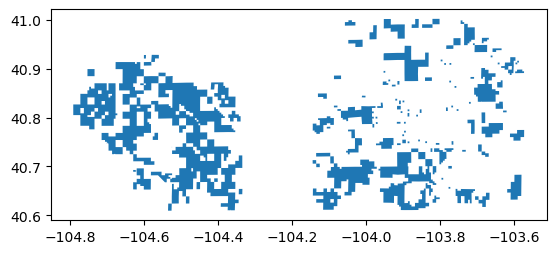

In [12]:
# Map of Pawnee
Pawnee_gdf = (gdf.set_index('GRASSLANDN')
               .loc[[ 
                     'Pawnee National Grassland',
                  ]])
Pawnee_gdf.plot()

<Axes: >

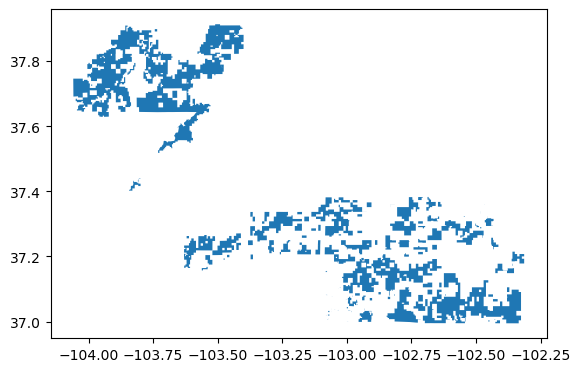

In [14]:
# Map of Comanche
Comanche_gdf = (gdf.set_index('GRASSLANDN')
               .loc[[
                     'Comanche National Grassland', 
                  ]])
Comanche_gdf.plot()

## Downloading soil pH data

### Data Citation:
Duke University. (2019). POLARIS Soil Properties v1.0: pH Mean 60-100 cm Depth [Data set]. Duke University Hydrology Laboratory. Accessed 2024-11-20 from http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/60_100/

In [15]:
def get_polaris_data(data_directory, input_gdf, index_col_name):
    """
    This function downloads Polaris soil data for the extent of each
    row in a geodataframe and creates a merged data array for each.
    Downloaded data is saved in individual folders for each row. Merged
    data arrays for each row are saved in "Merged_files" subfolder.

    Paramters
    ----------
    data_directory : path
        The path to the data directory. A sub-directory will be created
        within this directory for the soil data downloads.

    input_gdf: geopandas.GeoDataFrame
        A geodataframe that contains the areas of interest. Polaris soil
        data will be downloaded according to the bounds of each row in
        the dataframe.

    index_col_name: string
        A string containing the name of the geoDataFrame column that
        should be used as the index. This index will be used to name
        output files.

    Returns
    ----------
    output_lst: list of data arrays
        Returns a list of data arrays representing the merged Polaris
        tif data for each row in the input geodataframe
    """

    # Set index to specified index column
    input_gdf = input_gdf.reset_index().set_index(index_col_name)

    # Create dataframe of bounds of each gdf row
    bound_pd = pd.concat([input_gdf.bounds], axis=1)

    file_list = []
    # Loop through each row in the boundary dataframe
    for ind in bound_pd.index:
        print("\n", ind, ":")
        # Define and round min and max longitude and latitudes
        min_lon = math.floor(bound_pd["minx"][ind])
        max_lon = math.ceil(bound_pd["maxx"][ind])
        min_lat = math.floor(bound_pd["miny"][ind])
        max_lat = math.ceil(bound_pd["maxy"][ind])
        # Define range
        lat_range = range(min_lat, max_lat)
        lon_range = range(min_lon, max_lon)

        # Create template for polaris url path
        polaris_template_url = (
            "http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/"
            "{0}/{1}/{2}/lat{3}{4}_lon{5}{6}.tif"
        )
        # Create template for file names
        polaris_template_name = "mean_ph_lat{0}{1}_lon{2}{3}.tif"

        # Create sub-directory for soil data
        soil_dir = os.path.join(data_directory, "soil_data")
        if not os.path.exists(soil_dir):
            os.makedirs(soil_dir)

        # Create sub-folders for each row's data
        soil_row_dir = os.path.join(soil_dir, str(ind).replace(" ", "_"))
        if not os.path.exists(soil_row_dir):
            os.makedirs(soil_row_dir)

        # Create sub-folder for merged data arrays
        soil_merged_dir = os.path.join(soil_dir, "Merged_tifs")
        if not os.path.exists(soil_merged_dir):
            os.makedirs(soil_merged_dir)

        # For each latitude and longitude in the extent, download file
        for lat in lat_range:
            for lon in lon_range:
                # Define url for each data file in extent
                url = polaris_template_url.format(
                    "ph",
                    "mean",
                    "60_100",
                    str(lat),
                    str(lat + 1),
                    str(lon),
                    str(lon + 1),
                )
                # Define file name for each data file in extent
                file_name = polaris_template_name.format(
                    str(lat), str(lat + 1), str(lon), str(lon + 1)
                )
                # Check if tif file is in directory. Download if not.
                file_name_path = os.path.join(soil_row_dir, file_name)
                if not os.path.exists(file_name_path):
                    print(file_name, "does not exist. Downloading file")
                    r = requests.get(url, allow_redirects=True)
                    open(file_name_path, "wb").write(r.content)
                else:
                    print(file_name, "is already downloaded")

        # Define the name for the merged file
        merge_template_name = "{0}_merged_da.tif"
        merge_da_name = (
            merge_template_name.format(str(ind)
                                       .replace(" ", "_"), ".tif"))
        # Merge arrays if the merged file does not exist
        if not os.path.exists(os.path.join(soil_merged_dir, merge_da_name)):
            print("Soil data is being merged.")
            tif_paths = glob(os.path.join(soil_row_dir, "*.tif"))
            das = [rxr.open_rasterio(tif, masked=True) for tif in tif_paths]
            merged_da = rxrmerge.merge_arrays(das)
            merged_da.rio.to_raster(
                os.path.join(soil_merged_dir, merge_da_name)
                )
            print("Merged soil file created.")
        # Otherwise, load existing merged file
        else:
            print("A merged soil data array already exists.")
            merged_da = rxr.open_rasterio(
                os.path.join(soil_merged_dir, merge_da_name), masked=True
            )

        # Add file to list of tif files to return
        file_list.append(os.path.join(soil_merged_dir, merge_da_name))
    # Return files
    output_lst = [rxr.open_rasterio(tif, masked=True).squeeze() 
                  for tif in file_list]
    return output_lst


comanche_pH_da, pawnee_pH_da = get_polaris_data(
    data_dir, selectedgrass_gdf, "GRASSLANDN"
)


 Comanche National Grassland :
mean_ph_lat3637_lon-105-104.tif does not exist. Downloading file
mean_ph_lat3637_lon-104-103.tif does not exist. Downloading file
mean_ph_lat3637_lon-103-102.tif does not exist. Downloading file
mean_ph_lat3738_lon-105-104.tif does not exist. Downloading file
mean_ph_lat3738_lon-104-103.tif does not exist. Downloading file
mean_ph_lat3738_lon-103-102.tif does not exist. Downloading file
Soil data is being merged.
Merged soil file created.

 Pawnee National Grassland :
mean_ph_lat4041_lon-105-104.tif does not exist. Downloading file
mean_ph_lat4041_lon-104-103.tif does not exist. Downloading file
mean_ph_lat4142_lon-105-104.tif does not exist. Downloading file
mean_ph_lat4142_lon-104-103.tif does not exist. Downloading file
Soil data is being merged.
Merged soil file created.


In [16]:
# Change projection of grassland data
selectedgrass_utm_gdf = selectedgrass_gdf.to_crs(utm)
# Change crs of selected grasslands
selectedgrass_gdf = selectedgrass_gdf.to_crs(4326)

# Clip pH files to bounds
comanche_pH_da = (comanche_pH_da
                  .rio.reproject(utm)
                  .rio.clip_box(
                      *selectedgrass_utm_gdf
                      .loc[['Comanche National Grassland']]
                      .total_bounds)
)
pawnee_pH_da = (pawnee_pH_da
                  .rio.reproject(utm)
                  .rio.clip_box(
                      *selectedgrass_utm_gdf
                      .loc[['Pawnee National Grassland']]
                      .total_bounds)
)

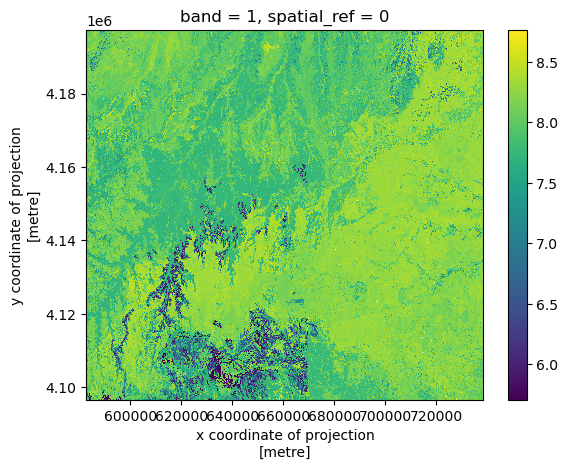

In [20]:
# Quick plot to see pH data of Comanche grassland
comanche_pH_da.plot()

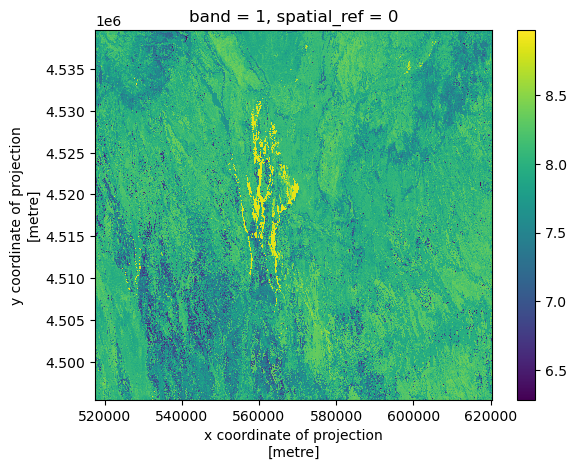

In [21]:
# Quick plot to see pH data of Pawnee grassland
pawnee_pH_da.plot()

## Downloading Elevation Data

### Data Citation:
NASA JPL (2013). NASA Shuttle Radar Topography Mission Global 1 arc second [Data set]. NASA EOSDIS Land Processes Distributed Active Archive Center. Accessed 2024-11-20 from https://doi.org/10.5067/MEaSUREs/SRTM/SRTMGL1.003

## Downloading "Climate" Variable 

### Data Citation: 

blah blah

## Calculating Slope

## Harmonizing the data

In [ ]:
# Making sure the grids of each of my data layers match up:

## Fuzzy logic model 